# Product Amount Forecast by Time

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

# 1. Libraries|User Defined Functions

## 1.1. Import Libraries

In [39]:
# !pip install pyforest
# 1-Import Libraies
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import missingno as msno 

from sklearn.compose import make_column_transformer

# Scaling
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


# Importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
import plotly.express as px
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

# Figure&Display options
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


import colorama
from colorama import Fore, Style  # maakes strings colored
from termcolor import colored

import ipywidgets
from ipywidgets import interact

## 1.2. Some Useful User Defined Functions

In [40]:
## Some Useful Functions

###############################################################################

def missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values[missing_values['Missing_Number']>0]

###############################################################################

def first_looking(df):
    print(colored("Shape:", attrs=['bold']), df.shape,'\n', 
          colored('-'*79, 'red', attrs=['bold']),
          colored("\nInfo:\n", attrs=['bold']), sep='')
    print(df.info(), '\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Number of Uniques:\n", attrs=['bold']), df.nunique(),'\n',
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Missing Values:\n", attrs=['bold']), missing_values(df),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("All Columns:", attrs=['bold']), list(df.columns),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')

    df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')

    print(colored("Columns after rename:", attrs=['bold']), list(df.columns),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    
        
def multicolinearity_control(df):
    feature =[]
    collinear=[]
    for col in df.corr().columns:
        for i in df.corr().index:
            if (abs(df.corr()[col][i])> .9 and abs(df.corr()[col][i]) < 1):
                    feature.append(col)
                    collinear.append(i)
                    print(colored(f"Multicolinearity alert in between:{col} - {i}", 
                                  "red", attrs=['bold']), df.shape,'\n',
                                  colored('-'*79, 'red', attrs=['bold']), sep='')

def duplicate_values(df):
    print(colored("Duplicate check...", attrs=['bold']), sep='')
    duplicate_values = df.duplicated(subset=None, keep='first').sum()
    if duplicate_values > 0:
        df.drop_duplicates(keep='first', inplace=True)
        print(duplicate_values, colored("Duplicates were dropped!"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    else:
        print(colored("There are no duplicates"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')     
        
def drop_columns(df, drop_columns):
    if drop_columns !=[]:
        df.drop(drop_columns, axis=1, inplace=True)
        print(drop_columns, 'were dropped')
    else:
        print(colored('We will now check the missing values and if necessary will drop realted columns!', attrs=['bold']),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
        
def drop_null(df, limit):
    print('Shape:', df.shape)
    for i in df.isnull().sum().index:
        if (df.isnull().sum()[i]/df.shape[0]*100)>limit:
            print(df.isnull().sum()[i], 'percent of', i ,'null and were dropped')
            df.drop(i, axis=1, inplace=True)
            print('new shape:', df.shape)       
    print('New shape after missing value control:', df.shape)
    
###############################################################################

# 2. Read dataset

In [41]:
df0 = pd.read_csv("data/Frozen_Dessert_Production.csv",
                   index_col='DATE',
                   parse_dates=True)
df = df0.copy()
df.head()
first_looking(df)
duplicate_values(df)
drop_columns(df,[])
drop_null(df, 90)

Shape:(573, 1)
-------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB
None
-------------------------------------------------------------------------------
Number of Uniques:
IPN31152N    573
dtype: int64
-------------------------------------------------------------------------------
Missing Values:
Empty DataFrame
Columns: [Missing_Number, Missing_Percent]
Index: []
-------------------------------------------------------------------------------
All Columns:['IPN31152N']
-------------------------------------------------------------------------------
Columns after rename:['ipn31152n']
-------------------------------------------------------------------------------
Duplicate check

In [42]:
df = df.rename(columns={'ipn31152n':'amount'})

In [43]:
df.head()

,amount
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [44]:
df.tail()

,amount
DATE,
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263
2019-08-01,102.609
2019-09-01,101.587


In [45]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
amount,573.000,109.896,27.951,58.660,88.936,107.643,128.278,196.174


### 3. Check missing values

In [46]:
missing_values(df)

,Missing_Number,Missing_Percent


### 4. Plot the distribution of various discrete features on (Season, haliday, weekend and weathercode)

In [47]:
df["year"] = df.index.year
df['month'] = df.index.month 
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
df['hour'] = df.index.hour 
df["date"] = df.index.date

In [48]:
df.head()

,amount,year,month,day,dayofweek,hour,date
DATE,,,,,,,
1972-01-01,59.962,1972,1,1,5,0,1972-01-01
1972-02-01,67.061,1972,2,1,1,0,1972-02-01
1972-03-01,74.235,1972,3,1,2,0,1972-03-01
1972-04-01,78.112,1972,4,1,5,0,1972-04-01
1972-05-01,84.764,1972,5,1,0,0,1972-05-01


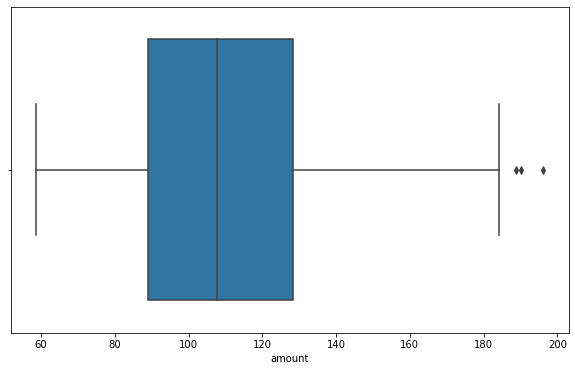

In [49]:
ax = sns.boxplot(x=df['amount'])

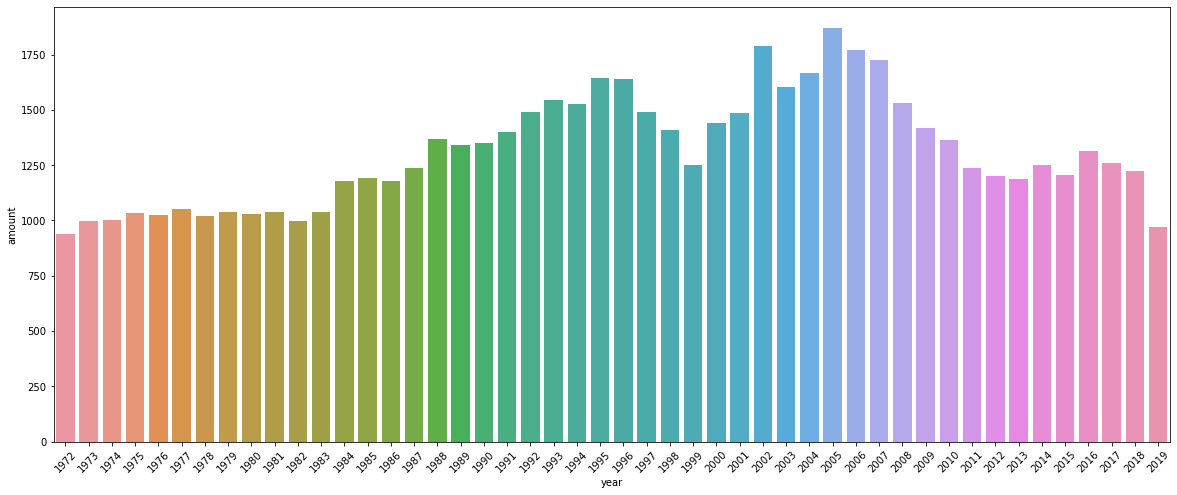

In [50]:
plt.figure(figsize=(20, 8))
sns.barplot(x='year', y='amount', data=df, ci=None, estimator=sum)
plt.xticks(rotation=45);

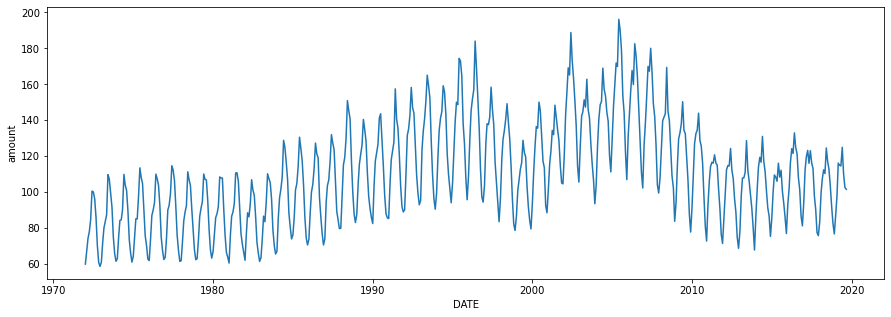

In [51]:
date_cnt = df.groupby("date")["amount"].sum()

plt.figure(figsize=(15,5))
sns.lineplot(x=df.index, y=df["amount"]);

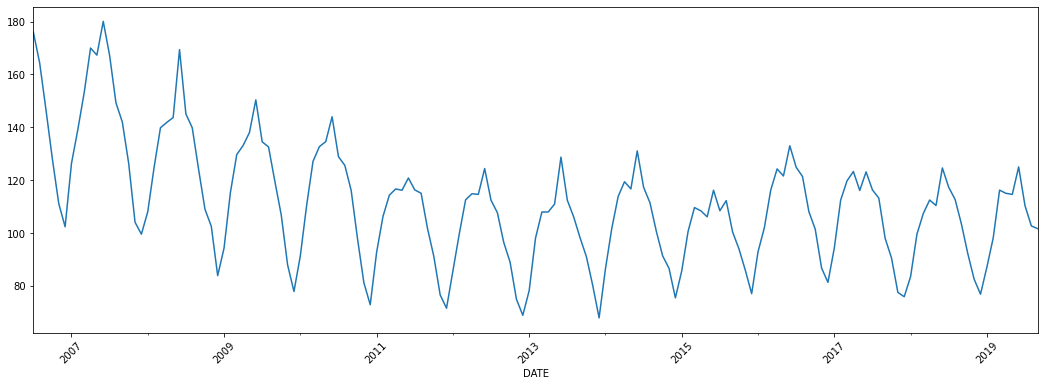

In [52]:
df['amount'].loc["2006-06-30":"2019-09-01"].plot(figsize=(18, 6))
plt.xticks(rotation=45);

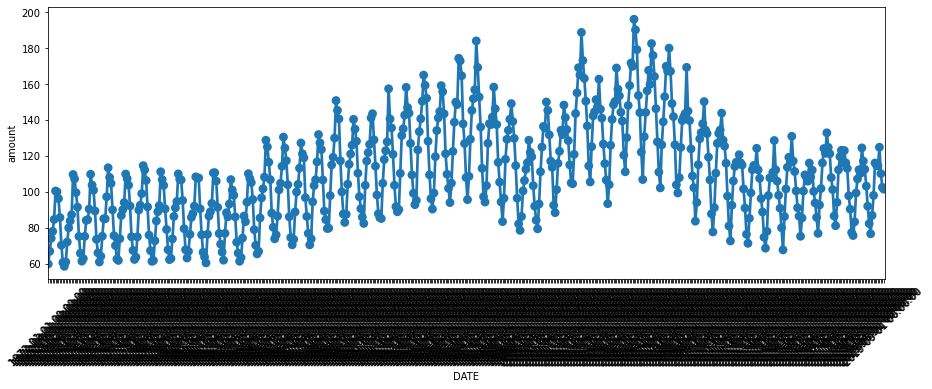

In [53]:
data_by_month = df.resample('M').sum()

plt.figure(figsize=(15, 5))
plt.xticks(rotation=45)
sns.pointplot(x=df.index, y=df["amount"]);

In [54]:
fig = px.line(df, x='year', y='amount', color='month', markers=True)
fig.show()

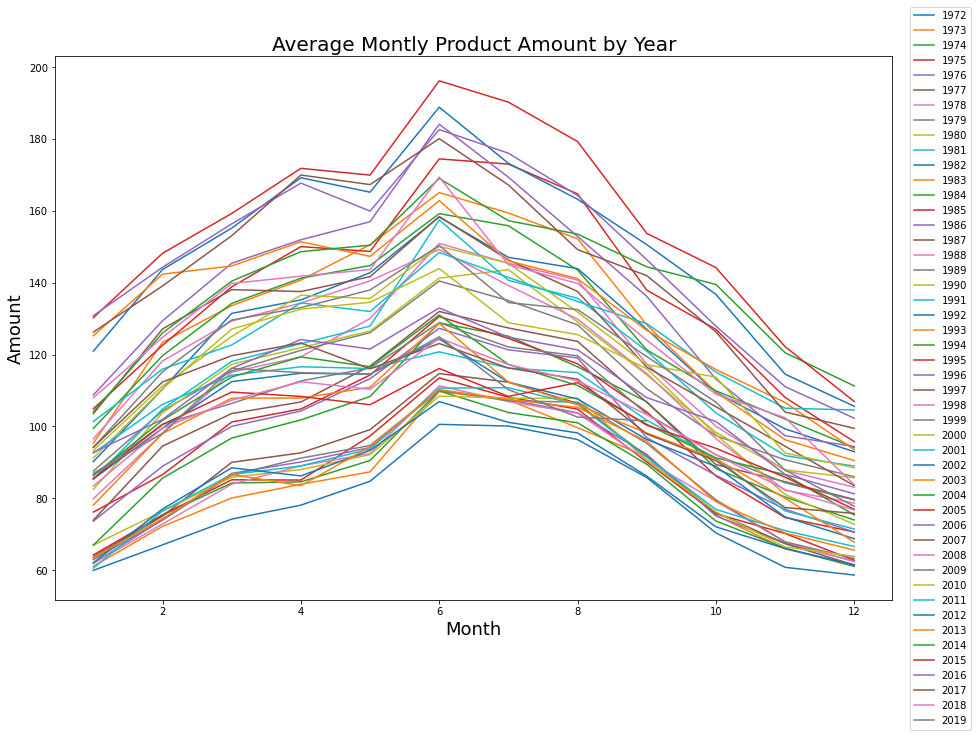

In [55]:
year_month_cnt = df.groupby(["year", "month"])["amount"].mean()

plt.figure(figsize=(15, 10))
for year in year_month_cnt.index.levels[0]:
    plt.plot(year_month_cnt[year].index, year_month_cnt[year], label=year)


plt.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1.1))
plt.xlabel('Month', fontsize=18)
plt.ylabel('Amount', fontsize=18)
plt.title('Average Montly Product Amount by Year', fontsize=20)
plt.show()

In [56]:
df.columns

Index(['amount', 'year', 'month', 'day', 'dayofweek', 'hour', 'date'], dtype='object')

In [57]:
df = df.drop(['year', 'month', 'day', 'dayofweek', 'hour', 'date'], axis=1)

In [34]:
df.head()

,amount
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


### 5. Preprocessing of Data

### Train Test Split

In [58]:
len(df)

573

In [59]:
len(df)- 72

501

In [60]:
test_size = 72

In [61]:
test_ind = len(df)- test_size

In [62]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [63]:
train.head()

,amount
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [64]:
test.head()

,amount
DATE,
2013-10-01,90.998
2013-11-01,80.069
2013-12-01,67.803
2014-01-01,86.397
2014-02-01,101.731


### Scaling

In [65]:
from sklearn.preprocessing import StandardScaler

In [66]:
scaler = StandardScaler()

In [67]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [68]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [69]:
length = 24
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = 1)

In [70]:
generator[0]

(array([[[-1.7428696 ],
         [-1.49951581],
         [-1.25354961],
         [-1.1206329 ],
         [-0.8925935 ],
         [-0.34980513],
         [-0.36590803],
         [-0.49500557],
         [-0.85703819],
         [-1.38525269],
         [-1.71390014],
         [-1.78752029],
         [-1.70387568],
         [-1.32310376],
         [-1.05253237],
         [-0.92199836],
         [-0.80319612],
         [-0.03608809],
         [-0.11740487],
         [-0.3817881 ],
         [-0.65728601],
         [-1.21686981],
         [-1.53812919],
         [-1.68910639]]]),
 array([[-1.6394229]]))

In [71]:
train_scaled

array([[-1.74286960e+00],
       [-1.49951581e+00],
       [-1.25354961e+00],
       [-1.12063290e+00],
       [-8.92593496e-01],
       [-3.49805126e-01],
       [-3.65908035e-01],
       [-4.95005574e-01],
       [-8.57038190e-01],
       [-1.38525269e+00],
       [-1.71390014e+00],
       [-1.78752029e+00],
       [-1.70387568e+00],
       [-1.32310376e+00],
       [-1.05253237e+00],
       [-9.21998361e-01],
       [-8.03196124e-01],
       [-3.60880940e-02],
       [-1.17404871e-01],
       [-3.81788102e-01],
       [-6.57286009e-01],
       [-1.21686981e+00],
       [-1.53812919e+00],
       [-1.68910639e+00],
       [-1.63942290e+00],
       [-1.21550533e+00],
       [-9.09574059e-01],
       [-8.98603374e-01],
       [-6.94576054e-01],
       [-3.07467416e-02],
       [-2.36865349e-01],
       [-3.35046126e-01],
       [-7.31029584e-01],
       [-1.27205579e+00],
       [-1.53048057e+00],
       [-1.70505160e+00],
       [-1.59532417e+00],
       [-1.21301293e+00],
       [-8.7

In [72]:
X, y = generator[0]

In [73]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[-1.7428696  -1.49951581 -1.25354961 -1.1206329  -0.8925935  -0.34980513
 -0.36590803 -0.49500557 -0.85703819 -1.38525269 -1.71390014 -1.78752029
 -1.70387568 -1.32310376 -1.05253237 -0.92199836 -0.80319612 -0.03608809
 -0.11740487 -0.3817881  -0.65728601 -1.21686981 -1.53812919 -1.68910639]
Predict this y: 
 [[-1.6394229]]


## Modelling & Model Performance

### Creating Model

### with "tanh" activation function

In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from keras.layers import Dropout

In [75]:
n_features = 1

In [76]:
model = Sequential()
model.add(LSTM(128, activation = 'tanh', input_shape = (length, n_features)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [77]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and Validation Generator

In [78]:
from tensorflow.keras.callbacks import EarlyStopping

In [79]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

In [80]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)

In [81]:
len(validation_generator)

48

In [82]:
model.fit_generator(generator, epochs = 64,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/64
477/477 [==============================] - 10s 15ms/step - loss: 0.3085 - val_loss: 0.0668
Epoch 2/64
477/477 [==============================] - 6s 13ms/step - loss: 0.0920 - val_loss: 0.0992
Epoch 3/64
477/477 [==============================] - 5s 10ms/step - loss: 0.0849 - val_loss: 0.0757
Epoch 4/64
477/477 [==============================] - 5s 11ms/step - loss: 0.0883 - val_loss: 0.0416
Epoch 5/64
477/477 [==============================] - 6s 13ms/step - loss: 0.0760 - val_loss: 0.0384
Epoch 6/64
477/477 [==============================] - 6s 12ms/step - loss: 0.0684 - val_loss: 0.0364
Epoch 7/64
477/477 [==============================] - 6s 12ms/step - loss: 0.0656 - val_loss: 0.0413
Epoch 8/64
477/477 [==============================] - 5s 10ms/step - loss: 0.0718 - val_loss: 0.0498
Epoch 9/64
477/477 [==============================] - 5s 10ms/step - loss: 0.0649 - val_loss: 0.0461
Epoch 10/64
477/477 [==============================] - 5s 10ms/step - loss: 0.0635 - val_l

<AxesSubplot:>

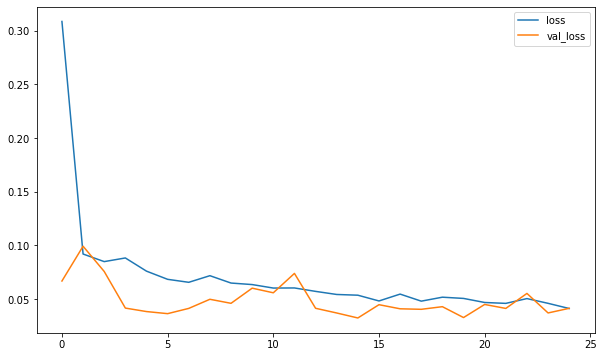

In [83]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [84]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [85]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)

In [86]:
validation_generator[0]

(array([[[-0.67885026],
         [-1.05352659],
         [-1.47405696],
         [-0.83657786],
         [-0.31090033],
         [ 0.10203626],
         [ 0.29325874],
         [ 0.1999222 ],
         [ 0.69390816],
         [ 0.22190814],
         [ 0.02120974],
         [-0.34907146],
         [-0.66982345],
         [-0.83058513],
         [-1.21446997],
         [-0.86471081],
         [-0.35110789],
         [-0.04184085],
         [-0.08357059],
         [-0.16255953],
         [ 0.18301706],
         [-0.08302549],
         [ 0.04819762],
         [-0.35829712]]]),
 array([[-0.57827993]]))

In [87]:
test_scaled

array([[-0.67885026],
       [-1.05352659],
       [-1.47405696],
       [-0.83657786],
       [-0.31090033],
       [ 0.10203626],
       [ 0.29325874],
       [ 0.1999222 ],
       [ 0.69390816],
       [ 0.22190814],
       [ 0.02120974],
       [-0.34907146],
       [-0.66982345],
       [-0.83058513],
       [-1.21446997],
       [-0.86471081],
       [-0.35110789],
       [-0.04184085],
       [-0.08357059],
       [-0.16255953],
       [ 0.18301706],
       [-0.08302549],
       [ 0.04819762],
       [-0.35829712],
       [-0.57827993],
       [-0.85486805],
       [-1.15961655],
       [-0.61671847],
       [-0.30255233],
       [ 0.18444325],
       [ 0.45978345],
       [ 0.36834622],
       [ 0.76065107],
       [ 0.48175225],
       [ 0.36109871],
       [-0.09474012],
       [-0.32280353],
       [-0.82741734],
       [-1.01281507],
       [-0.56752523],
       [ 0.0544612 ],
       [ 0.30508308],
       [ 0.42610345],
       [ 0.18047323],
       [ 0.42126264],
       [ 0

In [88]:
y_pred = model.predict(validation_generator)

In [89]:
y_pred

array([[-0.7048982 ],
       [-0.91339576],
       [-1.0368956 ],
       [-0.9221821 ],
       [-0.02120372],
       [ 0.11194507],
       [ 0.31814784],
       [ 0.7298031 ],
       [ 0.8197984 ],
       [ 0.50763047],
       [ 0.21593699],
       [-0.05397081],
       [-0.4905695 ],
       [-0.6191411 ],
       [-0.88068396],
       [-0.466437  ],
       [ 0.06562015],
       [ 0.26242507],
       [ 0.4270568 ],
       [ 0.8613032 ],
       [ 0.6184812 ],
       [ 0.21226165],
       [-0.04727287],
       [-0.27457193],
       [-0.7867983 ],
       [-0.9378432 ],
       [-1.1597785 ],
       [-0.6730409 ],
       [-0.3110371 ],
       [-0.07162666],
       [ 0.03389285],
       [ 0.46325338],
       [ 0.35446253],
       [ 0.15210545],
       [-0.04905499],
       [-0.3623944 ],
       [-0.69284856],
       [-1.0006515 ],
       [-1.0644208 ],
       [-0.74337506],
       [-0.12956151],
       [ 0.00803772],
       [ 0.23105001],
       [ 0.54559773],
       [ 0.614518  ],
       [ 0

In [90]:
len(y_pred)

48

In [91]:
test_scaled[24:]

array([[-0.57827993],
       [-0.85486805],
       [-1.15961655],
       [-0.61671847],
       [-0.30255233],
       [ 0.18444325],
       [ 0.45978345],
       [ 0.36834622],
       [ 0.76065107],
       [ 0.48175225],
       [ 0.36109871],
       [-0.09474012],
       [-0.32280353],
       [-0.82741734],
       [-1.01281507],
       [-0.56752523],
       [ 0.0544612 ],
       [ 0.30508308],
       [ 0.42610345],
       [ 0.18047323],
       [ 0.42126264],
       [ 0.18734363],
       [ 0.08133252],
       [-0.44180461],
       [-0.69684904],
       [-1.14374677],
       [-1.19949156],
       [-0.93816641],
       [-0.38772599],
       [-0.11944816],
       [ 0.05593539],
       [-0.01525408],
       [ 0.4725883 ],
       [ 0.2201734 ],
       [ 0.06440338],
       [-0.25669829],
       [-0.63997632],
       [-0.97243609],
       [-1.16695662],
       [-0.81596326],
       [-0.43497878],
       [ 0.18418613],
       [ 0.14299463],
       [ 0.12897272],
       [ 0.48549257],
       [-0

In [92]:
eval_metrics(test_scaled[24:], y_pred)

r2_score: 0.8538713536924949 
 mae: 0.1530000999654085 
 mse: 0.04142117599020126 
 rmse: 0.2035219299982222


In [93]:
test_predictions = []

first_eval_batch = train_scaled[-length:]

current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [94]:
train.shape

(501, 1)

In [95]:
eval_metrics(test_scaled, test_predictions)

r2_score: -2.9158272322811714 
 mae: 0.8601804188230866 
 mse: 1.1092958048908375 
 rmse: 1.0532311260548832


#### Inverse Transformations and Comparing

In [96]:
true_predictions = scaler.inverse_transform(test_predictions)

In [97]:
test

,amount
DATE,
2013-10-01,90.998
2013-11-01,80.069
2013-12-01,67.803
2014-01-01,86.397
2014-02-01,101.731
2014-03-01,113.776
2014-04-01,119.353
2014-05-01,116.631
2014-06-01,131.040


In [98]:
test['Predictions'] = true_predictions

In [99]:
test

,amount,Predictions
DATE,,
2013-10-01,90.998,86.823
2013-11-01,80.069,77.254
2013-12-01,67.803,74.827
2014-01-01,86.397,85.776
2014-02-01,101.731,103.595
2014-03-01,113.776,112.272
2014-04-01,119.353,116.013
2014-05-01,116.631,128.207
2014-06-01,131.040,133.690


<AxesSubplot:xlabel='DATE'>

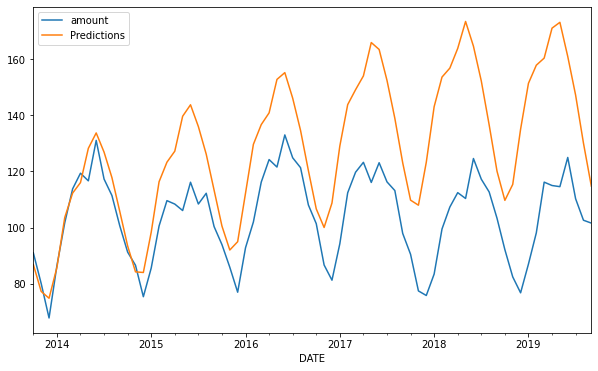

In [100]:
test.plot()

#### Calculation R2 Score and Error Metrics

In [101]:
eval_metrics(test.amount, test.Predictions)

r2_score: -2.9158271579166484 
 mae: 25.09029525604248 
 mse: 943.7996296374428 
 rmse: 30.72132206851526


### with "relu" activation function

In [102]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [103]:
n_features = 1

In [104]:
model = Sequential()
model.add(LSTM(128, activation = 'relu', input_shape = (length, n_features))) 
model.add(Dropout(0.2))
model.add(Dense(1)) 
model.compile(optimizer = 'adam', loss = 'mse')

In [105]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and Validation Generator

In [106]:
from tensorflow.keras.callbacks import EarlyStopping

In [107]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

In [108]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)

In [109]:
len(validation_generator)

48

In [110]:
model.fit_generator(generator, epochs = 64,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/64
477/477 [==============================] - 6s 9ms/step - loss: 0.7193 - val_loss: 0.2895
Epoch 2/64
477/477 [==============================] - 4s 8ms/step - loss: 0.4958 - val_loss: 0.1794
Epoch 3/64
477/477 [==============================] - 4s 9ms/step - loss: 0.2219 - val_loss: 0.0478
Epoch 4/64
477/477 [==============================] - 5s 10ms/step - loss: 0.1647 - val_loss: 0.0474
Epoch 5/64
477/477 [==============================] - 5s 10ms/step - loss: 0.1382 - val_loss: 0.0737
Epoch 6/64
477/477 [==============================] - 5s 10ms/step - loss: 0.1159 - val_loss: 0.0396
Epoch 7/64
477/477 [==============================] - 5s 11ms/step - loss: 0.1182 - val_loss: 0.0499
Epoch 8/64
477/477 [==============================] - 5s 10ms/step - loss: 0.1053 - val_loss: 0.0386
Epoch 9/64
477/477 [==============================] - 4s 9ms/step - loss: 0.0992 - val_loss: 0.0556
Epoch 10/64
477/477 [==============================] - 5s 10ms/step - loss: 0.1044 - val_loss: 

<AxesSubplot:>

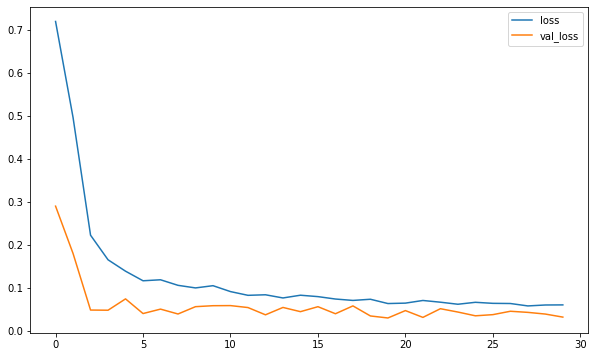

In [111]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [112]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [113]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)

In [114]:
y_pred = model.predict(validation_generator)

In [115]:
y_pred

array([[-0.73151976],
       [-0.87156796],
       [-1.0859429 ],
       [-0.8849511 ],
       [-0.08752717],
       [ 0.06434378],
       [ 0.31327352],
       [ 0.4998787 ],
       [ 0.5688105 ],
       [ 0.6215522 ],
       [ 0.3002169 ],
       [-0.03210489],
       [-0.4952327 ],
       [-0.64445096],
       [-1.0004938 ],
       [-0.6886965 ],
       [-0.00119668],
       [ 0.3371981 ],
       [ 0.49402505],
       [ 0.55746865],
       [ 0.4092577 ],
       [ 0.44045663],
       [ 0.11959146],
       [-0.17203672],
       [-0.73597175],
       [-0.8875588 ],
       [-1.1412174 ],
       [-0.67080736],
       [-0.323848  ],
       [-0.12163432],
       [ 0.00719011],
       [ 0.11746018],
       [ 0.23604387],
       [ 0.4871874 ],
       [ 0.16127223],
       [-0.1563027 ],
       [-0.5906411 ],
       [-0.89475954],
       [-0.9801526 ],
       [-0.57178295],
       [-0.1902316 ],
       [-0.04220961],
       [ 0.26869076],
       [ 0.3303636 ],
       [ 0.3863449 ],
       [ 0

In [116]:
test_scaled[24:]

array([[-0.57827993],
       [-0.85486805],
       [-1.15961655],
       [-0.61671847],
       [-0.30255233],
       [ 0.18444325],
       [ 0.45978345],
       [ 0.36834622],
       [ 0.76065107],
       [ 0.48175225],
       [ 0.36109871],
       [-0.09474012],
       [-0.32280353],
       [-0.82741734],
       [-1.01281507],
       [-0.56752523],
       [ 0.0544612 ],
       [ 0.30508308],
       [ 0.42610345],
       [ 0.18047323],
       [ 0.42126264],
       [ 0.18734363],
       [ 0.08133252],
       [-0.44180461],
       [-0.69684904],
       [-1.14374677],
       [-1.19949156],
       [-0.93816641],
       [-0.38772599],
       [-0.11944816],
       [ 0.05593539],
       [-0.01525408],
       [ 0.4725883 ],
       [ 0.2201734 ],
       [ 0.06440338],
       [-0.25669829],
       [-0.63997632],
       [-0.97243609],
       [-1.16695662],
       [-0.81596326],
       [-0.43497878],
       [ 0.18418613],
       [ 0.14299463],
       [ 0.12897272],
       [ 0.48549257],
       [-0

In [117]:
eval_metrics(test_scaled[24:], y_pred)

r2_score: 0.8894623444524274 
 mae: 0.14652967614244683 
 mse: 0.031332663373513314 
 rmse: 0.1770103482102482


In [118]:
test_predictions = []

first_eval_batch = train_scaled[-length:]

current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [119]:
eval_metrics(test_scaled, test_predictions)

r2_score: 0.3165094846310136 
 mae: 0.32873057661733335 
 mse: 0.19362273062793084 
 rmse: 0.44002582950087243


#### Inverse Transformations and Comparing

In [120]:
true_predictions_relu = scaler.inverse_transform(test_predictions)

In [121]:
test['Predictions_Relu'] = true_predictions_relu

In [123]:
test.head()

,amount,Predictions,Predictions_Relu
DATE,,,
2013-10-01,90.998,86.823,88.180
2013-11-01,80.069,77.254,80.911
2013-12-01,67.803,74.827,78.498
2014-01-01,86.397,85.776,88.204
2014-02-01,101.731,103.595,104.900


<AxesSubplot:xlabel='DATE'>

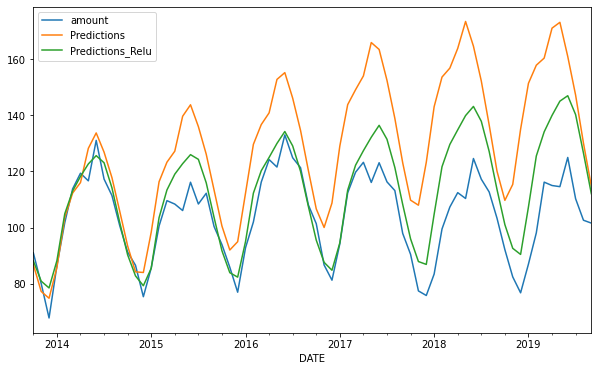

In [124]:
test.plot()

#### Calculation R2 Score and Error Metrics

In [125]:
eval_metrics(test.amount, test.Predictions_Relu)

r2_score: 0.31650947527814066 
 mae: 9.588624951002332 
 mse: 164.7361025087725 
 rmse: 12.83495627217999


## Retrain and Forecasting

Select activation function providing a better score, create your final model with full data, forecast for the next 12 months, and plot this forecast.

In [126]:
full_scaler = StandardScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [127]:
length = 24 
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = 1)

In [128]:
model = Sequential()
model.add(LSTM(55, activation = 'tanh', input_shape = (length, n_features)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=64)

Epoch 1/64
549/549 [==============================] - 8s 10ms/step - loss: 0.5283
Epoch 2/64
549/549 [==============================] - 5s 10ms/step - loss: 0.1159
Epoch 3/64
549/549 [==============================] - 5s 9ms/step - loss: 0.0880
Epoch 4/64
549/549 [==============================] - 5s 9ms/step - loss: 0.0750
Epoch 5/64
549/549 [==============================] - 5s 9ms/step - loss: 0.0817
Epoch 6/64
549/549 [==============================] - 5s 9ms/step - loss: 0.0770
Epoch 7/64
549/549 [==============================] - 5s 9ms/step - loss: 0.0718
Epoch 8/64
549/549 [==============================] - 5s 9ms/step - loss: 0.0706
Epoch 9/64
549/549 [==============================] - 5s 9ms/step - loss: 0.0717
Epoch 10/64
549/549 [==============================] - 5s 9ms/step - loss: 0.0709
Epoch 11/64
549/549 [==============================] - 5s 9ms/step - loss: 0.0663
Epoch 12/64
549/549 [==============================] - 5s 9ms/step - loss: 0.0622
Epoch 13/64
549/549 [==

In [129]:
scaled_full_data.shape

(573, 1)

In [130]:
scaled_full_data[-length:].shape

(24, 1)

In [131]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 24

first_eval_batch = scaled_full_data[-length:] 
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis = 1)

In [132]:
forecast = scaler.inverse_transform(forecast)

In [133]:
forecast

array([[ 91.0371  ],
       [ 81.288795],
       [ 77.27572 ],
       [ 90.07949 ],
       [108.53494 ],
       [117.36501 ],
       [118.87279 ],
       [124.47342 ],
       [133.09167 ],
       [124.40745 ],
       [116.08967 ],
       [103.091934],
       [ 91.3766  ],
       [ 82.02716 ],
       [ 80.53512 ],
       [ 98.12952 ],
       [114.47472 ],
       [120.732796],
       [120.92516 ],
       [129.21884 ],
       [132.05566 ],
       [125.3747  ],
       [114.59359 ],
       [102.3971  ]], dtype=float32)

In [135]:
df.head()

,amount
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [136]:
forecast_index = pd.date_range(start = '2019-10-01', periods = periods, freq = 'MS')

In [137]:
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
               '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
               '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [138]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [139]:
forecast_df

,Forecast
2019-10-01,91.037
2019-11-01,81.289
2019-12-01,77.276
2020-01-01,90.079
2020-02-01,108.535
2020-03-01,117.365
2020-04-01,118.873
2020-05-01,124.473
2020-06-01,133.092
2020-07-01,124.407


<AxesSubplot:>

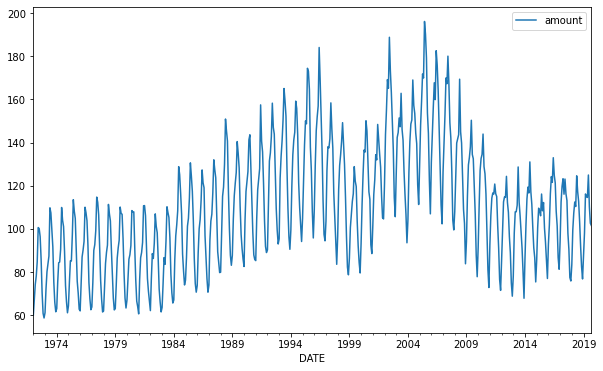

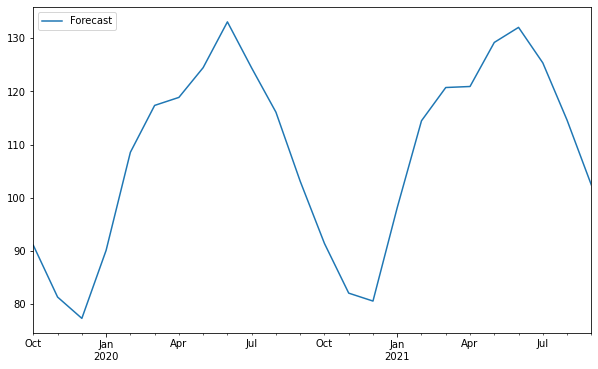

In [140]:
df.plot()
forecast_df.plot()

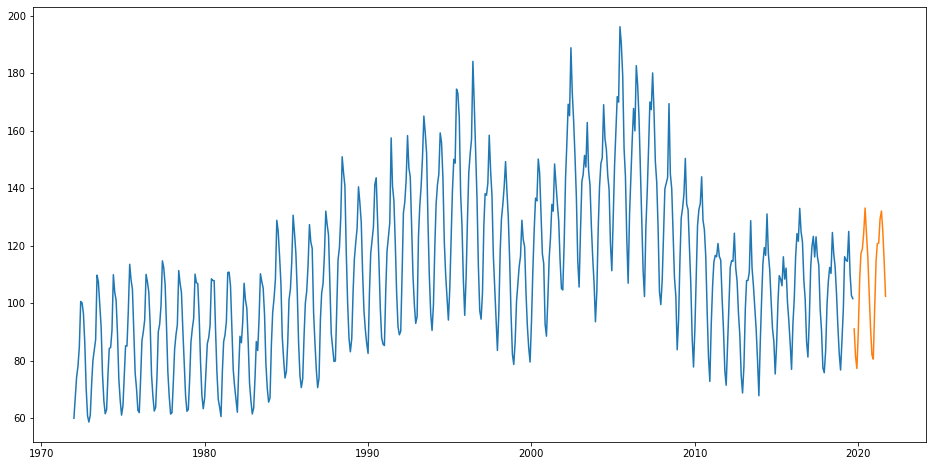

In [141]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['amount'])
plt.plot(forecast_df.index, forecast_df['Forecast'])
#plt.plot(forecast_index, forecast)

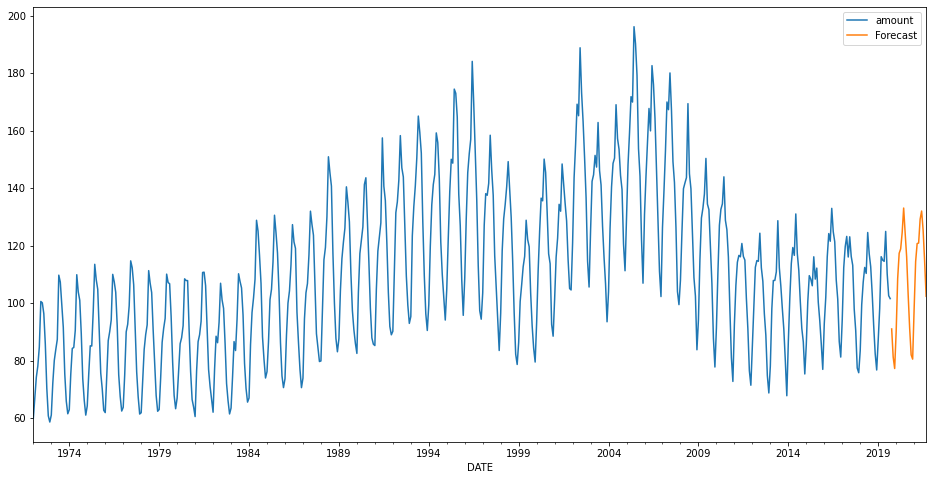

In [142]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(594.0, 598.0)

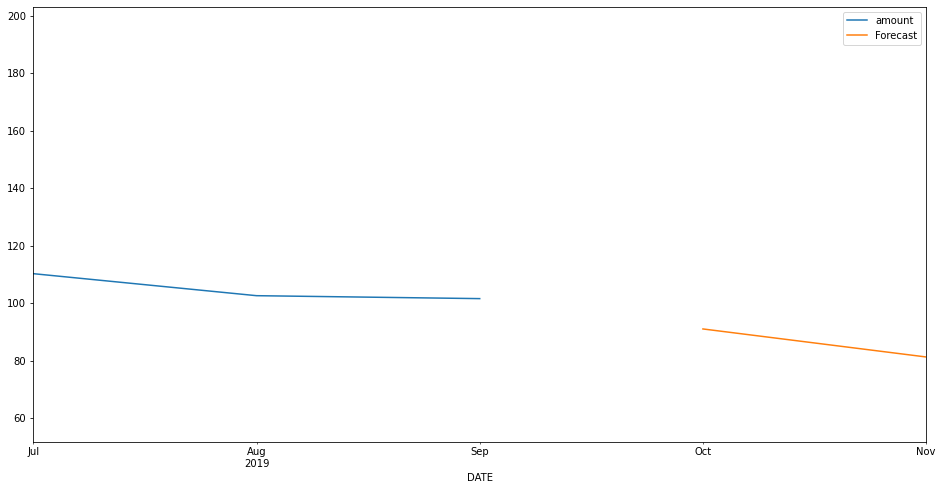

In [143]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2019-07-01', '2019-11-01')

# LAsT

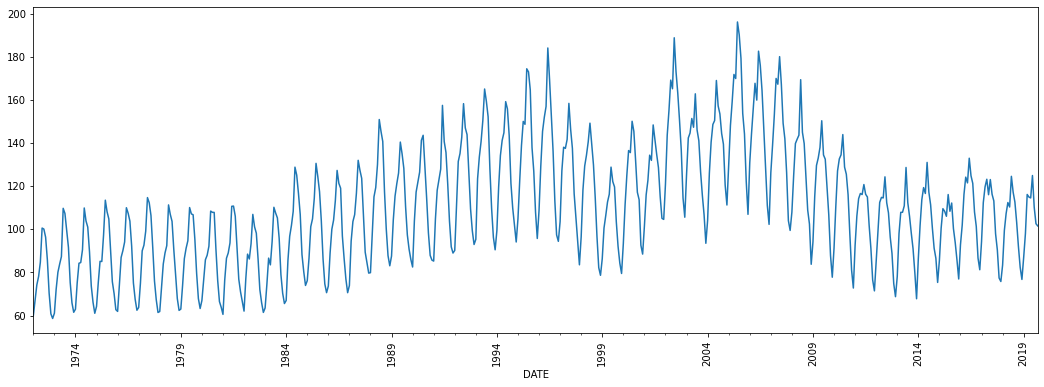

In [144]:
df['amount'].plot(figsize=(18,6))
plt.xticks(rotation=90);

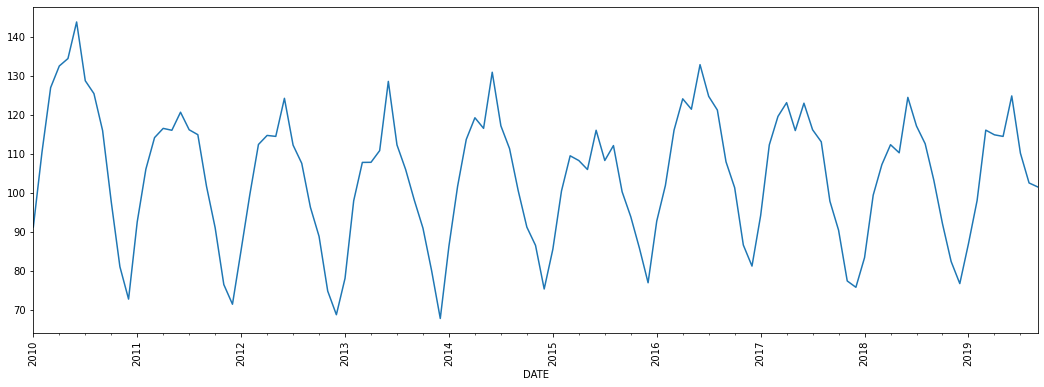

In [145]:
df['amount'].loc["2010-01-01" : "2019-09-01"].plot(figsize=(18,6))
plt.xticks(rotation=90);

In [146]:
df = df.loc["2010-01-01" : "2019-09-01"]
df

,amount
DATE,
2010-01-01,91.290
2010-02-01,110.499
2010-03-01,127.097
2010-04-01,132.647
2010-05-01,134.558
2010-06-01,143.952
2010-07-01,128.857
2010-08-01,125.556
2010-09-01,116.069


In [147]:
len(df)

117

### 5. Preprocessing of Data

### Train Test Split

In [148]:
len(df)

117

In [149]:
len(df) - 36

81

In [150]:
test_size = 36

In [151]:
test_ind = len(df)- test_size
test_ind

81

In [152]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [154]:
train.head()

,amount
DATE,
2010-01-01,91.290
2010-02-01,110.499
2010-03-01,127.097
2010-04-01,132.647
2010-05-01,134.558


In [155]:
test.head()

,amount
DATE,
2016-10-01,101.384
2016-11-01,86.665
2016-12-01,81.257
2017-01-01,94.245
2017-02-01,112.388


### Scaling

In [156]:
from sklearn.preprocessing import StandardScaler

In [157]:
scaler = StandardScaler()

In [158]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [159]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [160]:
length = 12
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = 1)

In [161]:
generator[0]

(array([[[-0.77649658],
         [ 0.32921347],
         [ 1.28456688],
         [ 1.60400421],
         [ 1.71398868],
         [ 2.25471882],
         [ 1.38584262],
         [ 1.19587938],
         [ 0.6497732 ],
         [-0.40451905],
         [-1.36374046],
         [-1.84188628]]]),
 array([[-0.70043185]]))

In [162]:
train_scaled

array([[-0.77649658],
       [ 0.32921347],
       [ 1.28456688],
       [ 1.60400421],
       [ 1.71398868],
       [ 2.25471882],
       [ 1.38584262],
       [ 1.19587938],
       [ 0.6497732 ],
       [-0.40451905],
       [-1.36374046],
       [-1.84188628],
       [-0.70043185],
       [ 0.0797626 ],
       [ 0.5450036 ],
       [ 0.68170714],
       [ 0.65368148],
       [ 0.92059586],
       [ 0.6608764 ],
       [ 0.58844367],
       [-0.17404551],
       [-0.7873235 ],
       [-1.62720128],
       [-1.9178992 ],
       [-1.11556741],
       [-0.30036534],
       [ 0.44360699],
       [ 0.57739227],
       [ 0.56328446],
       [ 1.12603107],
       [ 0.434409  ],
       [ 0.16480084],
       [-0.48406612],
       [-0.91481754],
       [-1.7234636 ],
       [-2.07275697],
       [-1.53466881],
       [-0.38828155],
       [ 0.17865538],
       [ 0.18015768],
       [ 0.35302003],
       [ 1.37630503],
       [ 0.43683801],
       [ 0.07337351],
       [-0.37923897],
       [-0

In [163]:
X_act, y_act= generator[0]

In [164]:
print(f'Given the Array: \n{X_act.flatten()}')
print(f'Predict this y: \n {y_act}')

Given the Array: 
[-0.77649658  0.32921347  1.28456688  1.60400421  1.71398868  2.25471882
  1.38584262  1.19587938  0.6497732  -0.40451905 -1.36374046 -1.84188628]
Predict this y: 
 [[-0.70043185]]


## Modelling & Model Performance

### Creating Model

### with "relu" activation function

In [165]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
n_features = 1
model = Sequential()
model.add(LSTM(80, activation = 'tanh', input_shape = (length, n_features)))
model.add(Dropout(0.2))
model.add(Dense(1)) 
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 80)                26240     
_________________________________________________________________
dropout_3 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 81        
Total params: 26,321
Trainable params: 26,321
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and Validation Generator

In [166]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)
model.fit_generator(generator, epochs = 50,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/50
69/69 [==============================] - 3s 13ms/step - loss: 0.6190 - val_loss: 0.1948
Epoch 2/50
69/69 [==============================] - 0s 6ms/step - loss: 0.2850 - val_loss: 0.1379
Epoch 3/50
69/69 [==============================] - 0s 6ms/step - loss: 0.1770 - val_loss: 0.1235
Epoch 4/50
69/69 [==============================] - 0s 7ms/step - loss: 0.1558 - val_loss: 0.1791
Epoch 5/50
69/69 [==============================] - 0s 6ms/step - loss: 0.1367 - val_loss: 0.0848
Epoch 6/50
69/69 [==============================] - 0s 7ms/step - loss: 0.1067 - val_loss: 0.0923
Epoch 7/50
69/69 [==============================] - 0s 7ms/step - loss: 0.1222 - val_loss: 0.1182
Epoch 8/50
69/69 [==============================] - 0s 6ms/step - loss: 0.1212 - val_loss: 0.0744
Epoch 9/50
69/69 [==============================] - 0s 7ms/step - loss: 0.1209 - val_loss: 0.1091
Epoch 10/50
69/69 [==============================] - 0s 7ms/step - loss: 0.1433 - val_loss: 0.1546
Epoch 11/50
69/69 

<AxesSubplot:>

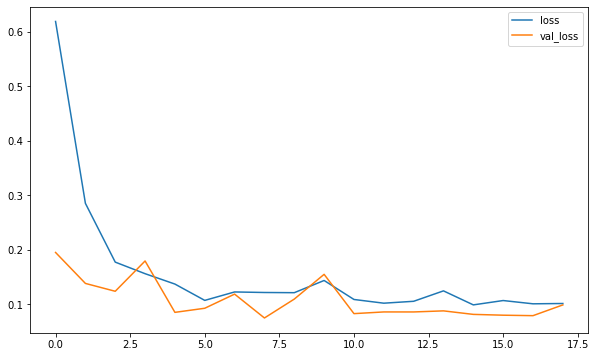

In [167]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [168]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)
y_pred = model.predict(validation_generator)
eval_metrics(test_scaled[12:], y_pred)

r2_score: 0.8657786511373893 
 mae: 0.24595988053550633 
 mse: 0.09841679014344938 
 rmse: 0.3137145041968085


In [169]:
test_predictions = []

first_eval_batch = train_scaled[-length:]

current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)
    
eval_metrics(test_scaled, test_predictions)

r2_score: 0.8802005780112296 
 mae: 0.250342588792638 
 mse: 0.08637864699562314 
 rmse: 0.293902444691471


#### Inverse Transformations and Comparing

In [170]:
true_predictions = scaler.inverse_transform(test_predictions)

In [171]:
test

,amount
DATE,
2016-10-01,101.384
2016-11-01,86.665
2016-12-01,81.257
2017-01-01,94.245
2017-02-01,112.388
2017-03-01,119.698
2017-04-01,123.228
2017-05-01,116.064
2017-06-01,123.087


In [172]:
test['predictions'] = true_predictions

In [173]:
test

,amount,predictions
DATE,,
2016-10-01,101.384,96.753
2016-11-01,86.665,85.297
2016-12-01,81.257,80.088
2017-01-01,94.245,92.023
2017-02-01,112.388,104.266
2017-03-01,119.698,112.135
2017-04-01,123.228,116.531
2017-05-01,116.064,119.676
2017-06-01,123.087,121.882


<AxesSubplot:xlabel='DATE'>

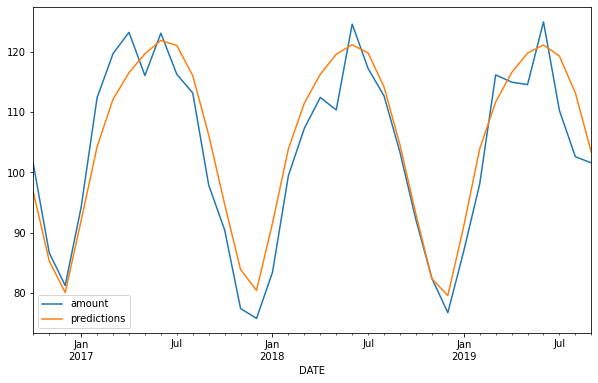

In [174]:
test.plot()

#### Calculation R2 Score and Error Metrics

In [175]:
eval_metrics(test.amount, test.predictions)

r2_score: 0.8802005758033602 
 mae: 4.349292065090603 
 mse: 26.071985277774953 
 rmse: 5.106073371757887
